In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install seqeval
!pip install sklearn_crfsuite

In [ ]:
## preparing dataset

import pandas as pd
import numpy as np



data = open("shuffled_train", "r").readlines()
data = [t[:-1] for t in data]

data_text = [t.split("\t")[0].split(' ')[1:-1] for t in data]  #.split(' ')[1:-1]
data_tag = [t.split("\t")[1].split(' ')[:-1] for t in data]  


# convert an empty 2D list into an empty 1D list
flatten = lambda l: [item for sublist in l for item in sublist]
words = list(set(flatten(data_text)))
n_words = len(words)


tags = list(set(flatten(data_tag)))
n_tags = len(tags)

#----

data_train = open("atis-2.train.w-intent.iob", "r").readlines()
data_train = [t[:-1] for t in data_train]

data_text_train = [t.split("\t")[0].split(' ')[1:-1] for t in data_train]  
data_tag_train = [t.split("\t")[1].split(' ')[:-1] for t in data_train]  

#---
data_test = open("atis-2.dev.w-intent.iob", "r").readlines()
data_test = [t[:-1] for t in data_test]

data_text_test = [t.split("\t")[0].split(' ')[1:-1] for t in data_test]  
data_tag_test = [t.split("\t")[1].split(' ')[:-1] for t in data_test] 



sentences_train = []
for i in range(0, len(data_text_train)):
	text = data_text_train[i]
	tag = data_tag_train[i]
	l = list(zip(text,tag))
	sentences_train.append(l)


sentences_test = []
for i in range(0, len(data_text_test)):
	text = data_text_test[i]
	tag = data_tag_test[i]
	l = list(zip(text,tag))
	sentences_test.append(l)



In [ ]:
#map the senctences to a sequence of numbers and then pad the sequence

max_len = 50
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
tag2idx["PAD"] = len(tag2idx)

# print(word2idx["Obama"])
# print(tag2idx["B-geo"])


from keras.preprocessing.sequence import pad_sequences
X_tr = [[word2idx[w[0]] for w in s] for s in sentences_train]
X_tr = pad_sequences(maxlen=max_len, sequences=X_tr, padding="post",truncating='post', value=n_words-1) #truncating='pre'

X_te = [[word2idx[w[0]] for w in s] for s in sentences_test]
X_te = pad_sequences(maxlen=max_len, sequences=X_te, padding="post",truncating='post', value=n_words-1) #truncating='pre'

y_tr = [[tag2idx[w[1]] for w in s] for s in sentences_train]
y_tr = pad_sequences(maxlen=max_len, sequences=y_tr, padding="post",truncating='post', value=tag2idx["PAD"])

y_te = [[tag2idx[w[1]] for w in s] for s in sentences_test]
y_te = pad_sequences(maxlen=max_len, sequences=y_te, padding="post",truncating='post', value=tag2idx["PAD"])

from keras.utils import to_categorical
y_tr = [to_categorical(i, num_classes=n_tags+1) for i in y_tr]
y_te = [to_categorical(i, num_classes=n_tags+1) for i in y_te]


In [ ]:
# import tensorflow
# tensorflow.reset_default_graph()

In [ ]:
### CRF-LSTM model

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=128,
                  input_length=max_len)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=256, return_sequences=True))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer
out = crf(model)  # output




model = Model(input, out)

model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=10,
                    validation_split=0.1, verbose=1)




W0805 10:42:29.620229 140120557860736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 10:42:29.656120 140120557860736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 10:42:29.664324 140120557860736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 10:42:30.458091 140120557860736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

/usr/local/lib/python3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 128)           1082752   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 512)           788480    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 50)            25650     
_________________________________________________________________
crf_1 (CRF)                  (None, 50, 36)            3204      
Total params: 1,900,086
Trainable params: 1,900,086
Non-trainable params: 0
_________________________________________________________________


W0805 10:42:32.603404 140120557860736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1914 samples, validate on 213 samples
Epoch 1/10
1914/1914 [==============================] - 18s 9ms/step - loss: 0.9070 - crf_viterbi_accuracy: 0.8417 - val_loss: 0.4491 - val_crf_viterbi_accuracy: 0.9278
Epoch 2/10
1914/1914 [==============================] - 13s 7ms/step - loss: 0.3509 - crf_viterbi_accuracy: 0.9318 - val_loss: 0.2690 - val_crf_viterbi_accuracy: 0.9399
Epoch 3/10
1914/1914 [==============================] - 13s 7ms/step - loss: 0.2121 - crf_viterbi_accuracy: 0.9450 - val_loss: 0.1891 - val_crf_viterbi_accuracy: 0.9539
Epoch 4/10
1914/1914 [==============================] - 13s 7ms/step - loss: 0.1330 - crf_viterbi_accuracy: 0.9647 - val_loss: 0.1476 - val_crf_viterbi_accuracy: 0.9605
Epoch 5/10
1914/1914 [==============================] - 13s 7ms/step - loss: 0.0901 - crf_viterbi_accuracy: 0.9746 - val_loss: 0.1146 - val_crf_viterbi_accuracy: 0.9721
Epoch 6/10
1914/1914 [==============================] - 13s 7ms/step - loss: 0.0648 - crf_viterbi_accuracy: 

In [ ]:
## Evaluation


from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
test_pred = model.predict(X_te, verbose=1)

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            if idx2tag[p_i]=="PAD":
              break
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

for i in range(len(test_labels)):
  if len(test_labels[i]) != len(pred_labels[i]):
    while len(test_labels[i]) != len(pred_labels[i]):
      pred_labels[i].append('O')



from sklearn_crfsuite.metrics import flat_classification_report
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)


532/532 [==============================] - 2s 3ms/step
                  precision    recall  f1-score   support

   B-bank_amount       0.00      0.00      0.00         3
        B-credit       0.00      0.00      0.00         1
    B-dec_amount       0.00      0.00      0.00         1
          B-dorm       0.71      0.72      0.71        74
         B-email       0.31      0.24      0.27        17
       B-faculty       0.67      0.75      0.71        48
         B-field       0.87      0.61      0.72        54
    B-food_price       0.00      0.00      0.00         1
         B-grade       0.96      0.87      0.91        92
    B-inc_amount       0.00      0.00      0.00         2
          B-meal       0.86      0.72      0.79        69
          B-name       0.96      0.71      0.82       190
 B-national_code       0.69      0.92      0.79        24
          B-pass       0.00      0.00      0.00         3
B-personnel_code       0.00      0.00      0.00         4
         B-phone

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
print(test_labels[3])

['O', 'O', 'B-meal', 'O', 'B-meal', 'O', 'O', 'O', 'O', 'O', 'B-student_num', 'B-phone']


In [ ]:
y_true = []
y_pred = []
for line in test_labels:
  for item in line:
    y_true.append(item)
for line in pred_labels:
  for item in line:
    y_pred.append(item)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_true=y_true, y_pred=y_pred, average='micro')

0.9601359525318277

[[15470     0     0 ...     0     0     0]
 [    3     0     0 ...     0     0     0]
 [    3     0     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    1     0     0 ...     0     0     0]
 [    1     0     0 ...     0     0     0]]


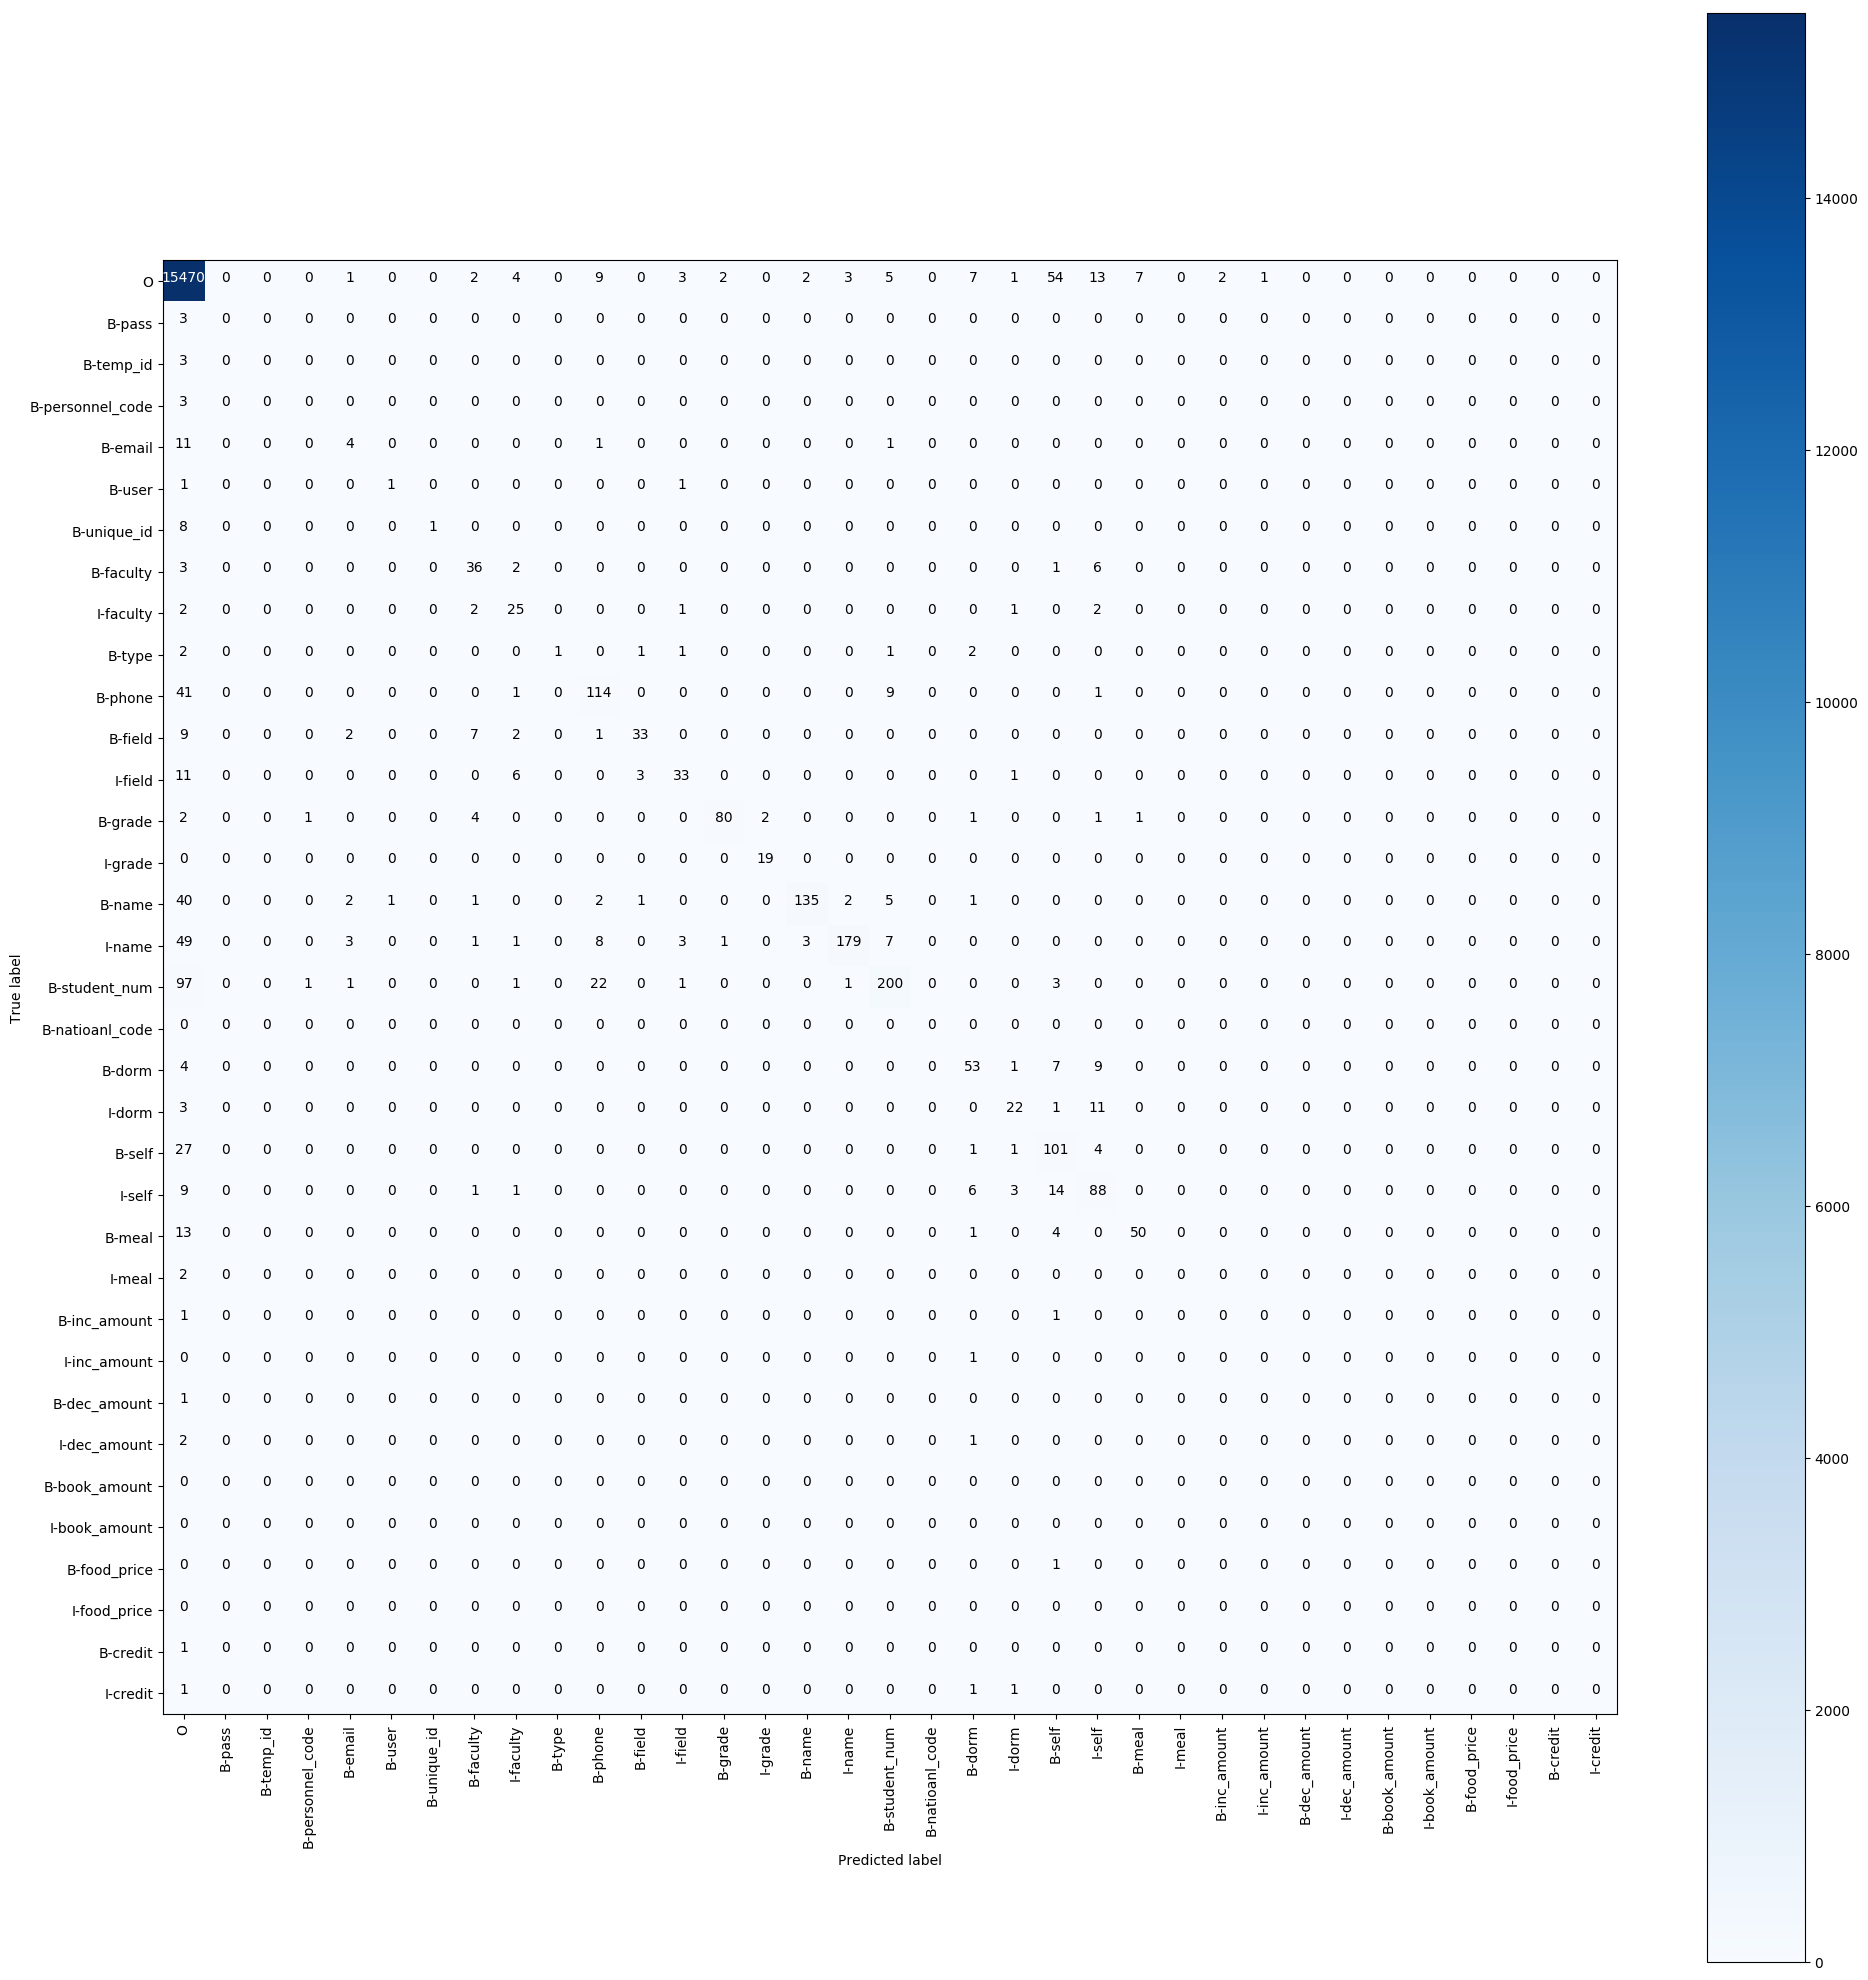

In [ ]:
#confusion matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    

    print(cm)
    plt.ion()
    plt.figure(num=None, figsize=(20, 20), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
labels = ['O','B-pass','B-temp_id','B-personnel_code','B-email','B-user','B-unique_id','B-faculty', 'I-faculty', 'B-type', 'B-phone', 'B-field', 'I-field', 'B-grade', 'I-grade', 'B-name', 'I-name', 'B-student_num', 'B-natioanl_code', 'B-dorm', 'I-dorm', 'B-self', 'I-self', 'B-meal', 'I-meal', 'B-inc_amount', 'I-inc_amount', 'B-dec_amount', 'I-dec_amount', 'B-book_amount', 'I-book_amount', 'B-food_price', 'I-food_price', 'B-credit', 'I-credit']    



cnf_matrix = confusion_matrix(y_true, y_pred,labels=labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')